<a href="https://colab.research.google.com/github/JRyanShue/DCGAN/blob/main/notebooks/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DCGAN
Code from the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks". 

#Dataset
I'll be using the CelebA dataset as the ground truth for the probability distribution. The GAN will be trained to generate faces.

In [ ]:
!gdown --id 12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg

In [ ]:
!unzip "/content/CelebA.zip" -d "/content/CelebA"

In [ ]:
!pip install tensorflow
!pip install tensorflow_datasets

In [ ]:
!sudo du CelebA
!sudo ls CelebA/img_align_celeba | wc -l

1743716	CelebA/img_align_celeba
1743720	CelebA
202599


In [ ]:
!pip install opencv-python

(218, 178, 3)


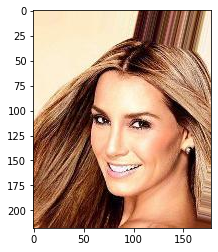

In [ ]:
# Test image read

import cv2
import matplotlib.pyplot as plt

# Read in image as ndarray
img = cv2.imread('CelebA/img_align_celeba/000001.jpg')
# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Starting images are 178px resolution
print(img.shape)

# print(img)
plt.imshow(img)

(178, 178, 3)


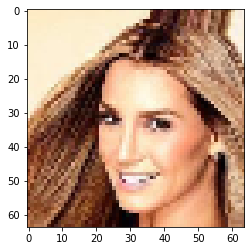

In [ ]:
# Test Image preprocessing

original_img = cv2.imread('CelebA/img_align_celeba/000001.jpg')

# Crop out top and bottom evenly to create a square image
crop_margin = int((original_img.shape[0] - original_img.shape[1]) / 2)
original_img = original_img[crop_margin:(original_img.shape[0] - crop_margin)]

print(original_img.shape)

# Resize to 64x64
img = cv2.resize(original_img, (64, 64))

# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [ ]:
!pip install tqdm

In [ ]:
import os
import numpy as np

directory = r'/content/CelebA/img_align_celeba'

filenames_list = os.listdir(directory)

In [ ]:
# Image getting and processing callback: 
# from image path, get processed 64x64 image
def img_path2data(img_path):

  # Read in image
  img = cv2.imread(directory + '/' + img_path)

  # Crop out top and bottom evenly to create a square image
  crop_margin = int((img.shape[0] - img.shape[1]) / 2)
  img = img[crop_margin:(img.shape[0] - crop_margin)]

  # Resize to 64x64
  img = cv2.resize(img, (64, 64))

  # BGR -> RGB
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Normalize from [0, 255] to [-1, 1]
  img = (img / (255.0/2)) - 1.0

  return img

In [ ]:
# Read images as dataset

from tqdm import tqdm
import tensorflow_datasets as tfds
import tensorflow as tf

SUBSET_AMOUNT = 100000

# Due to memory constraints, first map to a list of processed images, then load 
# into tf dataset. Takes about 10 min (most of the time converting list to ds)
# Would first convert to ndarray, but this consumes too much memory
ds = tf.data.Dataset.from_tensor_slices(list(tqdm(map(img_path2data, 
                                                      filenames_list[:100000]))))
# ds = tf.data.Dataset.from_tensor_slices(np_ds)

100000it [02:13, 748.39it/s]


In [ ]:
BATCH_SIZE = 128

# Batch dataset
ds = ds.batch(BATCH_SIZE)

In [ ]:
# Print out some batches

for i in ds.take(2):
  print(i)

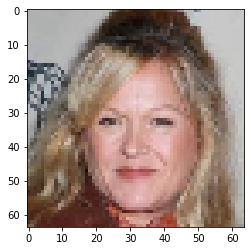

In [ ]:
# Sample dataset images

for i in ds.take(1):
  _ = (i+1.0)/2

plt.imshow(_[0])

#Training Loop

In [ ]:
# Define Generator and Discriminator

import tensorflow as tf

FINAL_DIM = 128
IMAGE_RES = 64
NOISE_DIM = 100

def Generator():
      
  def add_g_layer(x, filters):
    """
    Generator layers are made up of a fractionally-strided convolution 
    ("deconvolution"), BatchNorm, and ReLU activation. 
    """
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

  def output_g_layer(x):
    # Final fractionally-strided convolution ("deconvolution") into image space
    x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.math.tanh(x)
    return x

  # Define input noise vector shape
  noise_input = tf.keras.layers.Input(shape=(NOISE_DIM))

  # Initial projection into 4x4 feature maps
  x = tf.keras.layers.Dense(4 * 4 * (FINAL_DIM * 8), 
                            activation=None)(noise_input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Reshape((4, 4, (FINAL_DIM * 8)))(x)

  # Generator fractionally-strided convolutional layers
  x = add_g_layer(x, filters=FINAL_DIM * 4)
  x = add_g_layer(x, filters=FINAL_DIM * 2)
  x = add_g_layer(x, filters=FINAL_DIM)

  # Final convolution (convert feature maps into image)
  x = output_g_layer(x)

  # Model definition
  model = tf.keras.Model(inputs=noise_input, outputs=x, name='DCGAN_Generator')

  print(model.summary())

  return model


def Discriminator():

  """
  The Discriminator, for the most part, mirrors, the Generator. Key differences
  are 1) LeakyReLU(0.2) instead of ReLU, and 2) Output FC layer(1) with sigmoid
  activation.
  """

  def add_d_layer(x, filters):
    """
    Discriminator layers are made up of a strided convolutional layer 
    (downsampling without pooling), BatchNorm, and LeakyReLU (leak=0.2)
    """
    x = tf.keras.layers.Conv2D(filters, kernel_size=(5, 5), strides=(2, 2), 
                               padding='same', activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    return x

  def output_d_layer(x):
    """
    Final layer in Discriminator. Single neuron with sigmoid activation for
    classification of image as fake or real. 
    """
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    # CANNOT USE BATCHNORM HERE - WILL RESULT IN 0 GRADIENT BACKFLOW
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.math.sigmoid(x)
    return x

  """Start: Image of dimensions (64, 64, 3). End: Fake/real classification value 
  ranging [0, 1]"""

  image_input = tf.keras.layers.Input(shape=(IMAGE_RES, IMAGE_RES, 3))

  # Discriminator's strided convolutions
  x = add_d_layer(image_input, filters=FINAL_DIM)
  x = add_d_layer(x, filters=FINAL_DIM * 2)
  x = add_d_layer(x, filters=FINAL_DIM * 4)
  x = add_d_layer(x, filters=FINAL_DIM * 8)

  # Discriminator's output layer
  x = output_d_layer(x)

  model = tf.keras.Model(inputs=image_input, outputs=x, 
                         name='DCGAN_Discriminator')

  print(model.summary())

  return model

g = Generator()
d = Discriminator()


Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107712  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)    

In [ ]:
# Test noise input for Generator

def get_noise_samples(n_samples):
  return(np.random.rand(n_samples, 100))

rand_noise_vec = get_noise_samples(1)
rand_noise_vec

In [ ]:
# Feed noise into G and see what we get

test_img = g(rand_noise_vec)

print(test_img)

for img in test_img:
  plt.imshow((img+1)/2)

In [ ]:
# Define noise samples used for image generation after each epoch
# Used for testing fidelity/diversity qualitatively during training

noise_samples = get_noise_samples(16)

In [ ]:
!mkdir update_images

In [ ]:
# Optional: Load from saved checkpoint

g_path = '/content/models/g/cp'
d_path = '/content/models/d/cp'

g = Generator()
d = Discriminator()

g.load_weights(g_path)
d.load_weights(d_path)

In [ ]:
import time
from tensorflow.keras.optimizers import Adam

# Define training loop
# Note: print statements are commented out because they only work when
# @tf.function is commented out, and thus eager execution is enabled. 

EPOCHS = 100
D_STEPS = 1
G_STEPS = 1
BATCH_SIZE = 128

# Model checkpointing paths
g_cp_path = './g/cp'
d_cp_path = './d/cp'

# Set seed
np.random.seed(1)

# Optimizers
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Track current batch iteration
i = 0

# Losses

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Format from https://www.tensorflow.org/tutorials/generative/dcgan:
def d_loss(real_predictions, fake_predictions):

  # Track Discriminator predictions
  # real = real_predictions.numpy()[0][0]
  # fake = fake_predictions.numpy()[0][0]
  # print('R:', real)
  # print('F:', fake)
  # if abs(real - fake) < 0.5:
  #   print('Iterations until bug:', i)

  # Label all real predictions' ground truth as 1, compute b-crossentropy
  real_loss = cross_entropy(tf.ones_like(real_predictions), 
                                                   real_predictions)
  # Label all fake predictions' ground truth as 0, compute b-crossentropy
  fake_loss = cross_entropy(tf.zeros_like(fake_predictions),
                                                   fake_predictions)

  loss = real_loss + fake_loss
  # print('Loss:', loss.numpy())
  return loss

def d_real_loss(real_predictions):

  # Label all real predictions' ground truth as 1, compute b-crossentropy
  real_loss = cross_entropy(tf.ones_like(real_predictions), 
                                                   real_predictions)
  return real_loss

def d_fake_loss(fake_predictions):

  # Label all fake predictions' ground truth as 0, compute b-crossentropy
  fake_loss = cross_entropy(tf.zeros_like(fake_predictions),
                                                   fake_predictions)
  return fake_loss

def print_realandfake_d(data_examples):

  real_pred = d(data_examples)
  fake_pred = d(g(get_noise_samples(1)))  # , Training=True
  # print('NEW R:', real_pred.numpy()[0][0])
  # print('NEW F:', fake_pred.numpy()[0][0])

def g_loss(d_values):

  # Binary Crossentropy between the Discriminator outputs and 1 (which we'd like 
  # the Discriminator outputs to be)
  loss = cross_entropy(tf.ones_like(d_values), d_values)
  return loss

# Training step definitions
# Compiled for training

# Toggling @tf.function on will increase performance, but suppress eager 
# execution and prevent logging/displaying to the terminal
@tf.function
def d_train_step(data_examples):

  # All steps of the process must be within this indent for backpropagation to 
  # work
  with tf.GradientTape() as d_tape:

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator examples from the noise
    g_examples = g(noise_samples)

    # Run Discriminator and get loss
    loss = d_loss(d(data_examples, training=True), 
                       d(g_examples, training=True))

  # Get Discriminator gradients for fake loss with GradientTape
  d_grad = d_tape.gradient(loss, d.trainable_variables)

  # Apply gradients to model, zipping gradients with corresponding variables
  d_optimizer.apply_gradients(zip(d_grad, d.trainable_variables))

  # Print predictions for real and fake after gradient update
  print_realandfake_d(data_examples)

@tf.function
def g_train_step():

  with tf.GradientTape() as g_tape:

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator (fake) examples from the noise
    g_examples = g(noise_samples)

    # Run discriminator on generated samples
    d_values = d(g_examples, training=True)

    # Get loss
    loss = g_loss(d_values)

  # Use GradientTape to get all Generator gradients
  g_grad = g_tape.gradient(loss, g.trainable_variables)

  # Apply gradients
  g_optimizer.apply_gradients(zip(g_grad, g.trainable_variables))

# @tf.function
def train_step(epoch):

  print('Starting Epoch ' + str(epoch))
  time_cp = time.time()
  global i
  i = 0
  update_n = 0
  for batch in ds:

    # Train Discriminator to distinguish between the two
    for j in range(D_STEPS):
      d_train_step(batch)

    # Train Generator to maximize the probability of tricking the discriminator
    for j in range(G_STEPS):
      g_train_step()    

    i += 1
    update_batches = int(20000/128)
    if i % update_batches == 0:
      
      print('Update', i/update_batches, )
      print('Time elapsed for last ' + str(update_batches) + ' batches:', 
            time.time() - time_cp)
      time_cp = time.time()

      # Display array of generator images
      fig = plt.figure(figsize=(4, 4))
      g_images = g(noise_samples, training=False)
      for i in range(g_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((g_images[i].numpy()+1)/2)
        plt.axis('off')
      
      plt.savefig('update_images/img_at_epoch_{}_update_{}.png'.format(epoch, 
                                                                       update_n))
      plt.show()

      update_n += 1
    
  # Save weights
  print('Saving Weights...')
  g.save_weights(g_cp_path)
  d.save_weights(d_cp_path) 
  print('Weights saved.')

Starting Epoch 0
Update 1.0
Time elapsed for last 156 batches: 68.98370218276978


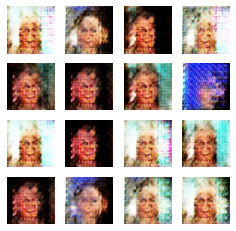

Update 1.0
Time elapsed for last 156 batches: 59.225900650024414


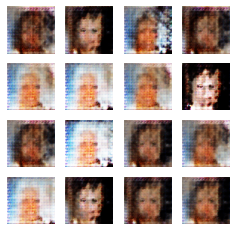

Update 1.0
Time elapsed for last 156 batches: 59.24246573448181


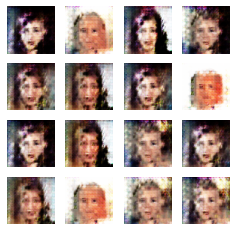

Update 1.0
Time elapsed for last 156 batches: 59.262083292007446


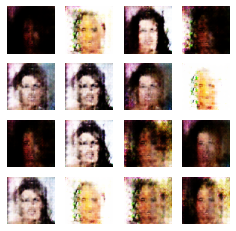

Update 1.0
Time elapsed for last 156 batches: 59.50001811981201


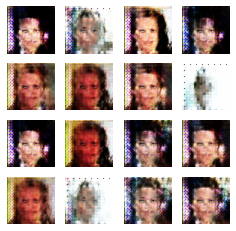

Saving Weights...
Weights saved.
Starting Epoch 1
Update 1.0
Time elapsed for last 156 batches: 67.3691155910492


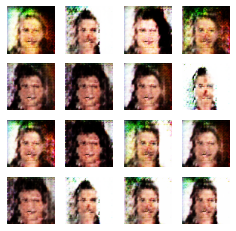

Update 1.0
Time elapsed for last 156 batches: 59.26480841636658


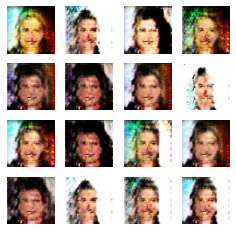

Update 1.0
Time elapsed for last 156 batches: 59.50872349739075


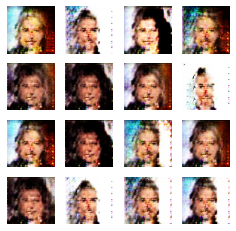

Update 1.0
Time elapsed for last 156 batches: 59.2194607257843


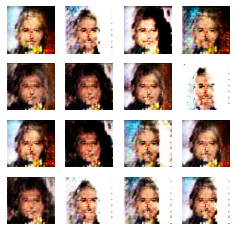

Update 1.0
Time elapsed for last 156 batches: 59.26674008369446


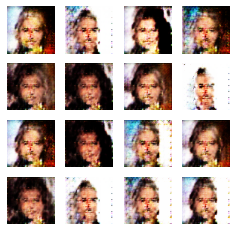

Saving Weights...
Weights saved.
Starting Epoch 2
Update 1.0
Time elapsed for last 156 batches: 67.06541728973389


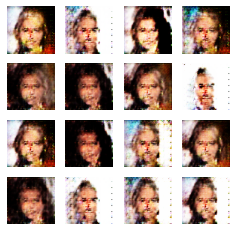

Update 1.0
Time elapsed for last 156 batches: 59.4980354309082


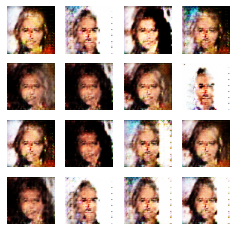

Update 1.0
Time elapsed for last 156 batches: 59.24444055557251


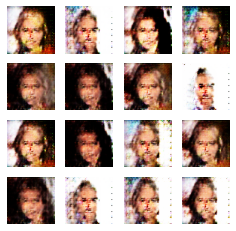

Update 1.0
Time elapsed for last 156 batches: 59.24924921989441


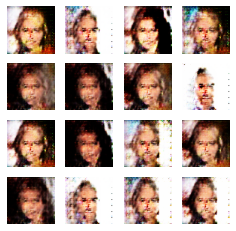

Update 1.0
Time elapsed for last 156 batches: 59.25825905799866


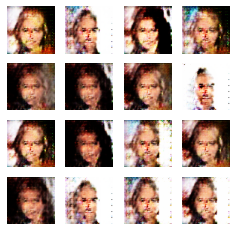

Saving Weights...
Weights saved.
Starting Epoch 3
Update 1.0
Time elapsed for last 156 batches: 67.01364874839783


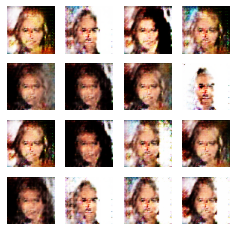

Update 1.0
Time elapsed for last 156 batches: 59.23953723907471


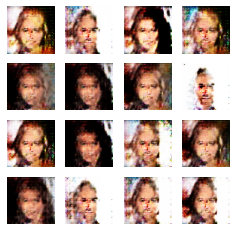

Update 1.0
Time elapsed for last 156 batches: 59.218926191329956


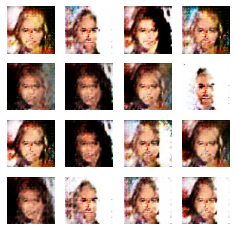

Update 1.0
Time elapsed for last 156 batches: 59.233808279037476


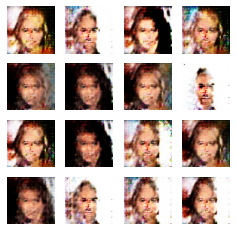

Update 1.0
Time elapsed for last 156 batches: 59.46697235107422


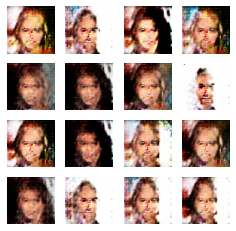

Saving Weights...
Weights saved.
Starting Epoch 4
Update 1.0
Time elapsed for last 156 batches: 67.21746826171875


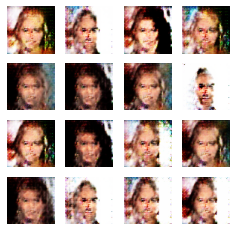

Update 1.0
Time elapsed for last 156 batches: 59.23490595817566


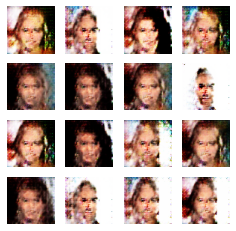

Update 1.0
Time elapsed for last 156 batches: 59.208390951156616


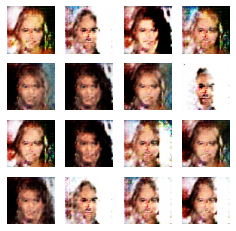

Update 1.0
Time elapsed for last 156 batches: 59.47666263580322


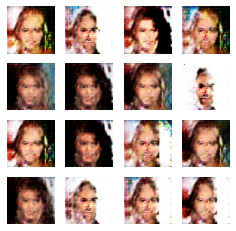

Update 1.0
Time elapsed for last 156 batches: 59.21610617637634


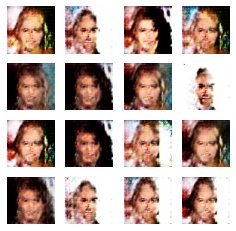

Saving Weights...
Weights saved.
Starting Epoch 5
Update 1.0
Time elapsed for last 156 batches: 67.18895316123962


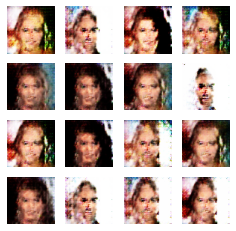

Update 1.0
Time elapsed for last 156 batches: 59.22138166427612


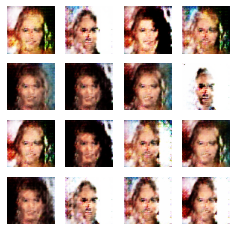

In [ ]:
# Train

def train(EPOCHS):

  for i in range(EPOCHS):

    train_step(i)

train(25)

In [ ]:
!zip -r /content/imgs.zip /content/update_images

In [ ]:
# Zip and download models

!rm -r models
!mkdir models
!mv d g models
!zip -r /content/models.zip /content/models

from google.colab import files
# files.download("/content/models.zip")


In [ ]:
test_img = g(rand_noise_vec)

print(test_img)

for img in test_img:
  plt.imshow((img + 1)/2)

In [ ]:
# Generator test

test_g_sample = g(get_noise_samples(100))
# test_real_sample = get_image_samples(1)

In [ ]:
plt.imshow((test_g_sample[4]+1)/2)

In [ ]:
# plt.imshow((test_real_sample[0]+1)/2)